Created by Marina Dunn, Spring 2022

**Resources used:**

https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2

https://github.com/deepskies/deepmerge-public/blob/master/DeepMerge-noisy.ipynb

https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

https://www.superdatascience.com/blogs/convolutional-neural-networks-cnn-softmax-crossentropy

In [39]:
# system level
import os
import codecs
import sys
import json
import h5py
import numpy as np
from numpy import random
from scipy import interp
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import __future__
import time
from pprint import pprint
from pathlib import Path
from datetime import datetime
import itertools
import warnings
warnings.filterwarnings("ignore")

# machine learning
import tensorflow as tf
#import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model, model_from_json, load_model
from tensorflow.keras.layers import BatchNormalization, Input, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, BackupAndRestore, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow_hub as hub
from tensorflow.keras import models
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, brier_score_loss

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# plotting
from tqdm import tqdm
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
import matplotlib
%matplotlib inline

### Load and define data

In [2]:
# Load year 1 train, test, validation image files
X_train_1 = np.load('images_Y1_train.npy')
X_test_1 = np.load('images_Y1_test.npy')
X_valid_1 = np.load('images_Y1_valid.npy')

In [3]:
# Load year 1, label small subset test files
X_test_1_sub = np.load('images_Y1_test_150.npy')
Y_test_sub = np.load('labels_test_150.npy')

In [4]:
# Load image label files
Y_train = np.load('labels_train.npy')
Y_test = np.load('labels_test.npy')
Y_valid = np.load('labels_valid.npy')

In [5]:
# initial training variables for model 1
# 70:10:20 for training:valid:test
NUM_TRAIN = 23487 # num train images
NUM_TEST = 6715 # num test images
NUM_VALIDATION = 3355 # num validation images
shuffle = True

In [6]:
# Shuffle data
random.seed(5)
idx = np.random.choice(len(X_train_1), size=len(X_train_1), replace=False)
X_train_1 = X_train_1[idx]
idx = np.random.choice(len(X_test_1), size=len(X_test_1), replace=False)
X_test_1 = X_test_1[idx]
idx = np.random.choice(len(X_valid_1), size=len(X_valid_1), replace=False)
X_valid_1 = X_valid_1[idx]

In [7]:
idx = np.random.choice(len(Y_train), size=len(Y_train), replace=False)
Y_train = Y_train[idx]
idx = np.random.choice(len(Y_test), size=len(Y_test), replace=False)
Y_test = Y_test[idx]
idx = np.random.choice(len(Y_valid), size=len(Y_valid), replace=False)
Y_valid = Y_valid[idx]

In [8]:
# cast data types as floats
X_train_1 = X_train_1.astype('float32')
X_test_1 = X_test_1.astype('float32')
X_valid_1 = X_valid_1.astype('float32')
X_test_1_sub = X_test_1_sub.astype('float32')

In [9]:
# check data sizes
NUM_TOTAL = NUM_TRAIN + NUM_TEST + NUM_VALIDATION
print(NUM_TOTAL)
assert NUM_TOTAL == len(X_train_1) + len(X_test_1) + len(X_valid_1), "total training, test, validation samples not equal to total samples - exiting"


33557


In [14]:
print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.9.0


### Exploratory Data Analysis

In [14]:
# Y_train_df = pd.DataFrame(Y_train)
# Y_test_df = pd.DataFrame(Y_test)
# Y_valid_df = pd.DataFrame(Y_valid)

In [15]:
#Y_train_df.info()
#Y_test_df.info()
#Y_valid_df.info()

In [16]:
#Y_train_df.value_counts()
#Y_test_df.value_counts()
#Y_valid_df.value_counts()

In [17]:
#Y_train_df.describe()
#Y_test_df.describe()
#Y_valid_df.describe()

In [12]:
print( "Data dimensions: ")
# training on year 1
print( "Training Set: ", np.shape(X_train_1), np.shape(Y_train)) # same for year 10
print( "Test Set: ", np.shape(X_test_1), np.shape(Y_test)) # same for year 10
print( "Validation Set: ", np.shape(X_valid_1), np.shape(Y_valid)) # same for year 10

Data dimensions: 
Training Set:  (23487, 3, 100, 100) (23487, 3)
Test Set:  (6715, 3, 100, 100) (6715, 3)
Validation Set:  (3355, 3, 100, 100) (3355, 3)


In [15]:
print("Subset Test Set: ", np.shape(X_test_1_sub))

Subset Test Set:  (150, 3, 100, 100)


Each image represents a series of pixels in a grid-like format with a value of brightness for each pixel.

```
Multi-Class Classification
3 columns: spiral (or '0'), elliptical ('1'), or a galaxy merger ('2’) - (num_classes – 1)
No null values, min:0, max:1

(year 1)
Training set details:
• 23487 total images
• 10017 Spiral galaxies (mean: 0.426491, std: 0.494577)
• 5705 Elliptical galaxies (mean: 0.242900, std: 0.428844)
• 7765 Merger galaxies (mean: 0.330608, std: 0.470442)
• Memory usage: 550.6 KB

Test set details:
• 6715 total images
• 2863 Spiral galaxies (mean: 0.426359, std: 0.494584)
• 1631 Elliptical galaxies (mean: 0.242889, std: 0.428861)
• 2221 Merger galaxies (mean: 0.330752, std: 0.470519)
• Memory usage: 157.5 KB

Validation set details:
• 3355 total images
• 1432 Spiral galaxies (mean: 0.426826, std: 0.494690)
• 815 Elliptical galaxies (mean: 0.242921, std: 0.428912)
• 1108 Merger galaxies (mean: 0.330253, std: 0.470374)
• Memory usage: 78.8 KB
```

## Deterministic CNN model:
First build a standard deterministic CNN classifier model as a baseline model. CNN/ConvNet typically uses convolutional layers, pooling layers, and fully-connected layers. The layer setup is such that simpler patterns are recognized first, then increasingly complex patterns thereafter. Perform series of convolution + pooling operations, then a number of fully connected layers. 

**Convolutional Layer:** Contains most of the network's main computational load. Performs dot product between kernel (matrix 1) and restricted portion of the receptive field (matrix 2). Forward pass. Creates an activation/feature map, or 2D representation of the image.

**Pooling Layer:** provides summary statistic of nearby outputs at various network output locations. Pooling operation performed individually on every slice of activation map. Max pooling is most popular.

**Fully Connected Layer:** helps map the representation b/w input and the output. Matrix multiplication, followed by a bias effect. Helps to learn non-linear combinations of features.

### Defining CNN model architecture:

#### Activation functions used:

**-ReLU/'relu':** Rectified Linear Unit, calculates ƒ(κ)=max (0,κ), or the activation is simply threshold at 0. More reliable + faster than sigmoid, tanh. More non-linearity gives more power to the model

**-Softmax/Normalized Exponential:** converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector. Because labels are one-hot encoded, this will be used for final fully connected layer for 3 classes.

#### Keras layers used:

**Convolution2D():** 2D convolution layer (e.g. spatial convolution over images). 

-args: activation (activation function to use); used with Rectified Linear Unit activation function for these models.

**MaxPooling2D():** Max pooling operation for 2D spatial data

-args: pool_size (window size over which to take the maximum), strides (Specifies how far the pooling window moves for each pooling step; sliding size of the kernel), padding (''valid"- no padding, or ''same"- padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input), data_format (ordering of the dimensions in the inputs)

used data_format='channels_first'

**Dense():** regular densely-connected neural network layer (describes a layer of neurons)

-args: activation (activation function to use), kernel_regularizer (regularizer function applied to the kernel weights matrix)

#### Regularization Techniques Used:
**Dropout:** Most popular regularization technique, prevents overfitting. At each iteration, neuron temporarily “dropped” with probability 'p'. This neuron is resampled with 'p' at every training step, so will be active at next step. Typically ~0.5 or 50%. Can be applied to input or hidden layer nodes, but not output nodes. Attempted to use rates of 0.5 and 0.8, as not enough computing power to use GridSearchCV to determine best rate.

**Batch Normalization:** Explicitly forces the activations throughout a network to take on a Gaussian distribution at the beginning of training, applying a transformation that maintains mean output close to 0 and output standard deviation close to 1. BatchNorm layer inserted immediately after fully connected layers, or convolutional layers, and before non-linearities. Significantly more robust to bad initialization.

**L2 Regularization**

#### Keras Callbacks used:
**Early stopping:** Early stopping call back function can be used to monitor either accuracy or loss, stopping when there's either a loss increment, or accuracy decrement. Should monitor the thing that is more sensitive, which is usually loss function- will start seeing signs of overfitting in loss earlier. 

**Model Checkpoint:** Save only best weights in order to maximize, in this case, validation accuracy (only saves when the model is considered the "best").

**ReduceLROnPlateau:** Attempt to adjust learning rate, in this case by 0.1, if validation loss begins to plateau. Did not implement until Model 2.

**BackupAndRestore:** Save backup of model in case training is interrupted.

#### Keras Optimizers used:  
**Adam:** implements the Adam algorithm; learning rate of 0.001. Stochastic gradient descent method based on adaptive estimation of 1st-order and 2nd-order moments, very performant and recommended by similar papers for this type of project.

#### Loss function used: 
**Categorical Cross-entropy:** Computes the cross-entropy loss between the labels and predictions. Used when adjusting model weights during training. Categorical cross-entropy is used with 'softmax' activation for multi-class classification problem, i.e. when true label values are one-hot encoded for 3-class classification problem, as is the case with this project.

#### Additional techniques to potentially look at:
**Cross validation:** (i.e. k-fold), partition the original training data set into k equal subsets, each called a fold (named f1, f2, …, fk, for i = 1 to i = k). Keep the fold fi as the Validation set, and keep all the remaining k-1 folds in the Cross validation training set. Train model using the cross validation training set; calculate accuracy by validating predicted results against the validation set. Estimate accuracy of model by averaging the accuracies derived in all the k cases of cross validation. Helps reduce overfitting problem.

**Choosing batch size, epoch:**

batch size: larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. 
epoch: models improve with more epochs of training, to a point; will start to plateau in accuracy as they converge. 

In [9]:
class_names = ['Spiral', 'Elliptical', 'Merger']
NUM_CLASSES = len(class_names)
print(class_names)

['Spiral', 'Elliptical', 'Merger']


### Model 1

In [25]:
# Defining model layers, build with the Functional API

#(channels, rows, cols)
input_shape = (3, 100, 100)

# Constraints for layer 1
# input: tensors of shape (color_channels, image_height, image_width), ignoring batch size
x = Input(shape=input_shape)
#For CNN: Convolution typically uses 3x3 windows, stride 1 & with padding. Will try 5x5 window first to attempt tp catch more features, but try multiple
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
# normalize input for first layer & also apply to each of the hidden layers
b0 = BatchNormalization()(c0)
#For CNN: pooling typically uses 2x2 windows, stride 2 & no padding
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.5)(d2)

#flatten (or unroll) the 3D output to 1D
f = Flatten()(e2)

# hidden layer
# Dense layer: takes 1D vector as input, current output is a 3D tensor; start simple, then change unit to try to increase performance
z0 = Dense(512, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(256, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
# use L2 regulization: take sum of all params squared & add it w/ square difference of actual output & predictions
# weights not sparse, will get much better accuracy than L1
z2 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(z1)
z3 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_4')(z2)
# output layer must create 3 output values, one for each class
# use “softmax” activation function to ensure output values are in range 0-1 & may be used as predicted probabilities
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z3)

model1 = Model(inputs=x, outputs=y, name="model_1")

# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
# Multi-Class Cross-Entropy Loss
loss = 'categorical_crossentropy' 

model1.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model1.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_10 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_10 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                           

In [26]:
NUM_EPOCH = 100
batch_size = 128

In [30]:
# monitoring validation loss as this tends to be more sensitive
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
     ModelCheckpoint(filepath='best_weights.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True),
    BackupAndRestore(backup_dir="model1/backup")] 


In [31]:
# Train Model 1
history = model1.fit(
                    X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=(X_valid_1, Y_valid),                
                    shuffle=True,
                    callbacks=es
            )

Epoch 1/100
184/184 [==============================] - ETA: 0s - loss: 1.2050 - accuracy: 0.4201WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 70s 382ms/step - loss: 1.2050 - accuracy: 0.4201 - val_loss: 1.1963 - val_accuracy: 0.4253
Epoch 2/100
184/184 [==============================] - ETA: 0s - loss: 1.1846 - accuracy: 0.4219WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 373ms/step - loss: 1.1846 - accuracy: 0.4219 - val_loss: 1.1873 - val_accuracy: 0.4268
Epoch 3/100
184/184 [==============================] - ETA: 0s - loss: 1.1666 - accuracy: 0.4247WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 373ms/step - loss: 1.1666 - accuracy: 0.4247 - val_loss: 1.1615 - val_accuracy: 0.4268
Epoch 4/100
184/184 [==============================] - ETA: 0s - loss: 1.1521 - accuracy: 0.4232WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 373ms/step - loss: 1.1521 - accuracy: 0.4232 - val_loss: 1.1457 - val_accuracy: 0.4268
Epoch 5/100
184/184 [==============================] - ETA: 0s - loss: 1.1414 - accuracy: 0.4236WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 68s 372ms/step - loss: 1.1414 - accuracy: 0.4236 - val_loss: 1.1363 - val_accuracy: 0.4268
Epoch 6/100
184/184 [==============================] - ETA: 0s - loss: 1.1328 - accuracy: 0.4236WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 71s 385ms/step - loss: 1.1328 - accuracy: 0.4236 - val_loss: 1.1271 - val_accuracy: 0.4262
Epoch 7/100
184/184 [==============================] - ETA: 0s - loss: 1.1228 - accuracy: 0.4259WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 376ms/step - loss: 1.1228 - accuracy: 0.4259 - val_loss: 1.1192 - val_accuracy: 0.4268
Epoch 8/100
184/184 [==============================] - ETA: 0s - loss: 1.1164 - accuracy: 0.4256WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 70s 379ms/step - loss: 1.1164 - accuracy: 0.4256 - val_loss: 1.1128 - val_accuracy: 0.4268
Epoch 9/100
184/184 [==============================] - ETA: 0s - loss: 1.1105 - accuracy: 0.4255WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 375ms/step - loss: 1.1105 - accuracy: 0.4255 - val_loss: 1.1074 - val_accuracy: 0.4268
Epoch 10/100
184/184 [==============================] - ETA: 0s - loss: 1.1058 - accuracy: 0.4258WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 375ms/step - loss: 1.1058 - accuracy: 0.4258 - val_loss: 1.1032 - val_accuracy: 0.4268
Epoch 11/100
184/184 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.4256WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 70s 378ms/step - loss: 1.1023 - accuracy: 0.4256 - val_loss: 1.0999 - val_accuracy: 0.4268
Epoch 12/100
184/184 [==============================] - ETA: 0s - loss: 1.0991 - accuracy: 0.4259WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 377ms/step - loss: 1.0991 - accuracy: 0.4259 - val_loss: 1.0982 - val_accuracy: 0.4268
Epoch 13/100
184/184 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.4259WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 375ms/step - loss: 1.0962 - accuracy: 0.4259 - val_loss: 1.0944 - val_accuracy: 0.4268
Epoch 14/100
184/184 [==============================] - ETA: 0s - loss: 1.0934 - accuracy: 0.4259WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 375ms/step - loss: 1.0934 - accuracy: 0.4259 - val_loss: 1.0931 - val_accuracy: 0.4268
Epoch 15/100
184/184 [==============================] - ETA: 0s - loss: 1.0916 - accuracy: 0.4257WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 377ms/step - loss: 1.0916 - accuracy: 0.4257 - val_loss: 1.0910 - val_accuracy: 0.4268
Epoch 16/100
184/184 [==============================] - ETA: 0s - loss: 1.0903 - accuracy: 0.4258WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 374ms/step - loss: 1.0903 - accuracy: 0.4258 - val_loss: 1.0892 - val_accuracy: 0.4268
Epoch 17/100
184/184 [==============================] - ETA: 0s - loss: 1.0881 - accuracy: 0.4259WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 68s 372ms/step - loss: 1.0881 - accuracy: 0.4259 - val_loss: 1.0880 - val_accuracy: 0.4262
Epoch 18/100
184/184 [==============================] - ETA: 0s - loss: 1.0879 - accuracy: 0.4249WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 377ms/step - loss: 1.0879 - accuracy: 0.4249 - val_loss: 1.0872 - val_accuracy: 0.4268
Epoch 19/100
184/184 [==============================] - ETA: 0s - loss: 1.0861 - accuracy: 0.4257WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 377ms/step - loss: 1.0861 - accuracy: 0.4257 - val_loss: 1.0861 - val_accuracy: 0.4262
Epoch 20/100
184/184 [==============================] - ETA: 0s - loss: 1.0851 - accuracy: 0.4259WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 374ms/step - loss: 1.0851 - accuracy: 0.4259 - val_loss: 1.0855 - val_accuracy: 0.4268
Epoch 21/100
184/184 [==============================] - ETA: 0s - loss: 1.0853 - accuracy: 0.4252WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 376ms/step - loss: 1.0853 - accuracy: 0.4252 - val_loss: 1.0854 - val_accuracy: 0.4268
Epoch 22/100
184/184 [==============================] - ETA: 0s - loss: 1.0842 - accuracy: 0.4271WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 375ms/step - loss: 1.0842 - accuracy: 0.4271 - val_loss: 1.0865 - val_accuracy: 0.4268
Epoch 23/100
184/184 [==============================] - ETA: 0s - loss: 1.0848 - accuracy: 0.4275WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 70s 378ms/step - loss: 1.0848 - accuracy: 0.4275 - val_loss: 1.0891 - val_accuracy: 0.4212
Epoch 24/100
184/184 [==============================] - ETA: 0s - loss: 1.0861 - accuracy: 0.4253WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 376ms/step - loss: 1.0861 - accuracy: 0.4253 - val_loss: 1.0879 - val_accuracy: 0.4238
Epoch 25/100
184/184 [==============================] - ETA: 0s - loss: 1.0851 - accuracy: 0.4279WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 375ms/step - loss: 1.0851 - accuracy: 0.4279 - val_loss: 1.0878 - val_accuracy: 0.4259
Epoch 26/100
184/184 [==============================] - ETA: 0s - loss: 1.0860 - accuracy: 0.4291WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 69s 376ms/step - loss: 1.0860 - accuracy: 0.4291 - val_loss: 1.0910 - val_accuracy: 0.4277
Epoch 26: early stopping


In [37]:
model1.save('model_1')

INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets


In [38]:
# Evaluate the model on test data
score = model1.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (model1.metrics_names[1], score[1]*100))

210/210 [==============================] - 3s 14ms/step - loss: 1.0969 - accuracy: 0.4134
accuracy: 41.34%


In [34]:
# Evaluate the model on test smaller subset
score = model1.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (model1.metrics_names[1], score[1]*100))

5/5 [==============================] - 0s 22ms/step - loss: 1.1145 - accuracy: 0.3467
accuracy: 34.67%


### Visualizing training results

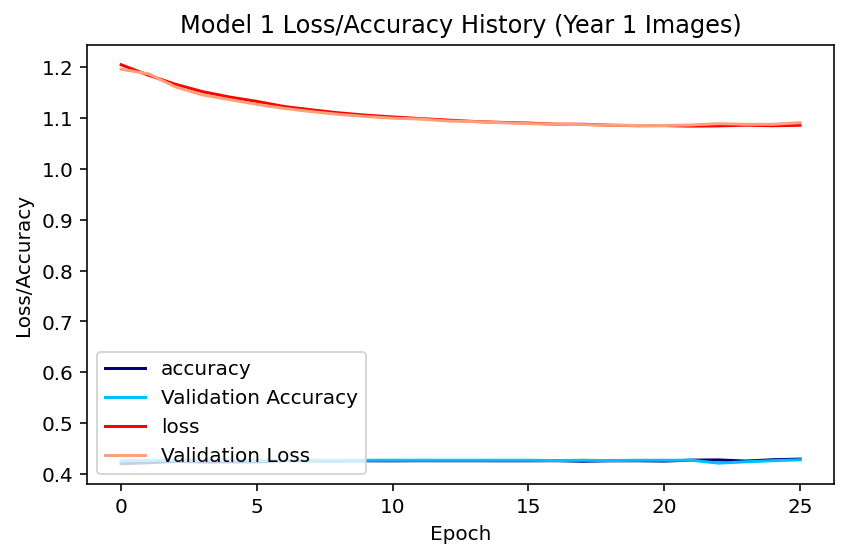

In [39]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Model 1 Loss/Accuracy History (Year 1 Images)")
plt.tight_layout()
axis1.legend(loc='lower left')

In [ ]:
prob = model1.predict(X_test_1)
pred = np.round(prob, 0).astype('int32')

# Classification report
classification_metrics = classification_report(Y_test, pred, target_names=class_names)
pprint(classification_metrics)

In [ ]:
# Accuracy, Precision, Recall scores
labels = [0, 1, 2]
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='samples')
print('Precision (samples): %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred, labels=labels, average='samples')
print('Recall (samples): %f' % recall)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='micro')
print('Precision (micro): %f' % precision)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='weighted')
print('Precision (weighted): %f' % precision)

In [ ]:
# Make Confusion matrix
categorical_test_labels = pd.DataFrame(Y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion Matrix',
   cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    
plot_confusion_matrix(confusion_matrix, class_names)

### Model 2
Changes:

Added image augmentation

Increased dropout rates to 0.8 after first dropout layer

Increased the number of layers and filter size

Added padding to Maxpool

Added callback to change Learning rate at plateau

In [34]:
input_shape = (3, 100, 100)

# Constraints for block 1
inputs = Input(shape=input_shape)
x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first', name='conv_1')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_1')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 2
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_3')(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_4')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_2')(x)
x = Dropout(rate=0.8)(x)

# Constraints for block 3
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_5')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_6')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_7')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_3')(x)
x = Dropout(rate=0.8)(x)

# Constraints for block 4
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_8')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_9')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_10')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_4')(x)
x = Dropout(rate=0.8)(x)

# Constraints for block 5
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_11')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_12')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_13')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_5')(x)
x = Dropout(rate=0.8)(x)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(x)

# hidden layers
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(x)
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(x)
x = Dense(1000, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(x)
outputs = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model2 = Model(inputs=inputs, outputs=outputs, name="model_2")

# Compile model
model2.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model2.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 100, 100)      4864      
                                                                 
 conv_2 (Conv2D)             (None, 64, 100, 100)      36928     
                                                                 
 batch_normalization_15 (Bat  (None, 64, 100, 100)     400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 64, 50, 50)        0         
                                                                 
 dropout_15 (Dropout)        (None, 64, 50, 50)        0         
                                                           

In [35]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.2,               
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      vertical_flip = True,
      horizontal_flip=True)

image_gen_valid = ImageDataGenerator(
      rescale=1./255)

In [36]:
TrainImage = image_gen_train.flow(x=X_train_1, y=Y_train)

ValidImage = image_gen_valid.flow(x=X_valid_1, y=Y_valid)

In [40]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5),
      BackupAndRestore(backup_dir='backups'),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='best_weights.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)]


In [14]:
batch_size = 128
NUM_EPOCH = 100

In [65]:
history2 =  model2.fit(TrainImage,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=ValidImage,
                    shuffle=True,
                    verbose=True,
                    callbacks=es
            )

Epoch 1/100


2022-05-31 10:20:50.312010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - ETA: 0s - loss: 2.1122 - accuracy: 0.4187

2022-05-31 10:33:39.348530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 787s 1s/step - loss: 2.1122 - accuracy: 0.4187 - val_loss: 1.5917 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 2/100
734/734 [==============================] - ETA: 0s - loss: 1.4284 - accuracy: 0.4230WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 794s 1s/step - loss: 1.4284 - accuracy: 0.4230 - val_loss: 1.2944 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 3/100
734/734 [==============================] - ETA: 0s - loss: 1.2348 - accuracy: 0.4248WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 793s 1s/step - loss: 1.2348 - accuracy: 0.4248 - val_loss: 1.1815 - val_accuracy: 0.4221 - lr: 0.0010
Epoch 4/100
734/734 [==============================] - ETA: 0s - loss: 1.1511 - accuracy: 0.4250WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 797s 1s/step - loss: 1.1511 - accuracy: 0.4250 - val_loss: 1.1230 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 5/100
734/734 [==============================] - ETA: 0s - loss: 1.1072 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 809s 1s/step - loss: 1.1072 - accuracy: 0.4265 - val_loss: 1.0958 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 6/100
734/734 [==============================] - ETA: 0s - loss: 1.1042 - accuracy: 0.4256WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 797s 1s/step - loss: 1.1042 - accuracy: 0.4256 - val_loss: 1.0894 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 7/100
734/734 [==============================] - ETA: 0s - loss: 1.0843 - accuracy: 0.4264WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 800s 1s/step - loss: 1.0843 - accuracy: 0.4264 - val_loss: 1.0795 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 8/100
734/734 [==============================] - ETA: 0s - loss: 1.0775 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 805s 1s/step - loss: 1.0775 - accuracy: 0.4265 - val_loss: 1.0758 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 9/100
734/734 [==============================] - ETA: 0s - loss: 1.0749 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 803s 1s/step - loss: 1.0749 - accuracy: 0.4265 - val_loss: 1.0742 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 10/100
734/734 [==============================] - ETA: 0s - loss: 1.0739 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 806s 1s/step - loss: 1.0739 - accuracy: 0.4265 - val_loss: 1.0734 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 11/100
734/734 [==============================] - ETA: 0s - loss: 1.0735 - accuracy: 0.4264WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 804s 1s/step - loss: 1.0735 - accuracy: 0.4264 - val_loss: 1.0734 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 12/100
734/734 [==============================] - ETA: 0s - loss: 1.0755 - accuracy: 0.4262WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 806s 1s/step - loss: 1.0755 - accuracy: 0.4262 - val_loss: 1.0735 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 13/100
734/734 [==============================] - ETA: 0s - loss: 1.0735 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 809s 1s/step - loss: 1.0735 - accuracy: 0.4265 - val_loss: 1.0732 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 14/100
557/734 [=====================>........] - ETA: 14:51 - loss: 1.0727 - accuracy: 0.4268

KeyboardInterrupt: 

In [23]:
# Evaluate the model on test data
test_score = model2.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (model2.metrics_names[1], test_score[1]*100))

210/210 [==============================] - 35s 163ms/step - loss: 1.0731 - accuracy: 0.4264
accuracy: 42.64%


In [24]:
# Evaluate the model on test smaller subset
test_sub_score = model2.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (model2.metrics_names[1], test_sub_score[1]*100))

5/5 [==============================] - 1s 153ms/step - loss: 1.1251 - accuracy: 0.3333
accuracy: 33.33%


### Visualizing training results

In [ ]:
# Accuracy
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

# Loss
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Model 2 Loss/Accuracy History (Year 1 Images)")
plt.tight_layout()
axis1.legend(loc='lower left')

In [ ]:
prob = model2.predict(X_test_1)
pred = np.round(prob, 0).astype('int32')

# Classification report
classification_metrics = classification_report(Y_test, pred, target_names=class_names)
pprint(classification_metrics)

In [ ]:
# Accuracy, Precision, Recall scores
labels = [0, 1, 2]
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='samples')
print('Precision (samples): %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred, labels=labels, average='samples')
print('Recall (samples): %f' % recall)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='micro')
print('Precision (micro): %f' % precision)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='weighted')
print('Precision (weighted): %f' % precision)

In [ ]:
# Make Confusion matrix
categorical_test_labels = pd.DataFrame(Y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion Matrix',
   cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    
plot_confusion_matrix(confusion_matrix, class_names)

### Model 3
changes:

edit dropout placement and size

decrease batch size

edit image augmentation

In [48]:
input_shape = (3, 100, 100)

# Constraints for block 1
inputs = Input(shape=input_shape)
x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first', name='conv_1')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_1')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 2
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_3')(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_4')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_2')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 3
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_5')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_6')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_7')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_3')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 4
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_8')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_9')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_10')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_4')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 5
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_11')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_12')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_13')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_5')(x)
x = Dropout(rate=0.5)(x)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(x)

# hidden layers
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(x)
x = Dropout(rate=0.5)(x)
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(x)
x = Dropout(rate=0.5)(x)
x = Dense(1000, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(x)
x = Dropout(rate=0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model3 = Model(inputs=inputs, outputs=outputs, name="model_3")

# Compile model
model3.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 100, 100)      4864      
                                                                 
 conv_2 (Conv2D)             (None, 64, 100, 100)      36928     
                                                                 
 batch_normalization_25 (Bat  (None, 64, 100, 100)     400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 64, 50, 50)        0         
                                                                 
 dropout_28 (Dropout)        (None, 64, 50, 50)        0         
                                                           

In [49]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.6,               
      height_shift_range=0.6,
      shear_range=0.6,
      zoom_range=0.6,
      vertical_flip = True,
      horizontal_flip = True)

image_gen_valid = ImageDataGenerator(
      rescale=1./255)

In [50]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5),
      ModelCheckpoint(filepath='best_weights.h5', monitor='val_acc', mode='max', 
        save_best_only=True)] 

In [51]:
batch_size = 64
NUM_EPOCH = 100

In [53]:
# Train model 3 on batches with data augmentation
history3 = model3.fit(image_gen_train.flow(X_train_1, Y_train),
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=image_gen_valid.flow(X_valid_1, Y_valid),
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

Epoch 1/100
734/734 [==============================] - ETA: 0s - loss: 2.0023 - accuracy: 0.4142

2022-05-31 19:45:04.147918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 794s 1s/step - loss: 2.0023 - accuracy: 0.4142 - val_loss: 1.6703 - val_accuracy: 0.4268
Epoch 2/100
734/734 [==============================] - 788s 1s/step - loss: 1.5101 - accuracy: 0.4236 - val_loss: 1.4335 - val_accuracy: 0.4009
Epoch 3/100
734/734 [==============================] - 796s 1s/step - loss: 1.3240 - accuracy: 0.4224 - val_loss: 1.2526 - val_accuracy: 0.4268
Epoch 4/100
734/734 [==============================] - 800s 1s/step - loss: 1.2242 - accuracy: 0.4246 - val_loss: 1.1701 - val_accuracy: 0.4268
Epoch 5/100
734/734 [==============================] - 789s 1s/step - loss: 1.1481 - accuracy: 0.4253 - val_loss: 1.1280 - val_accuracy: 0.4268
Epoch 6/100
734/734 [==============================] - 793s 1s/step - loss: 1.1134 - accuracy: 0.4246 - val_loss: 1.0993 - val_accuracy: 0.4268
Epoch 7/100
734/734 [==============================] - 794s 1s/step - loss: 1.0931 - accuracy: 0.4253 - val_loss: 1.0863 - val_accuracy: 0.4268
Epoc

KeyboardInterrupt: 

In [57]:
model3.save('model3')

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


### Visualizing training results

In [55]:
# Accuracy
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

# Loss
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Model 3 Loss/Accuracy History (Year 1 Images)")
plt.tight_layout()
axis1.legend(loc='lower left')

NameError: name 'history3' is not defined

In [56]:
prob = model3.predict(X_test_1)
pred = np.round(prob, 0).astype('int32')

# Classification report
classification_metrics = classification_report(Y_test, pred, target_names=class_names)
pprint(classification_metrics)

2022-05-31 23:13:49.017123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 72/210 [=========>....................] - ETA: 21s

KeyboardInterrupt: 

In [ ]:
# Accuracy, Precision, Recall scores
labels = [0, 1, 2]
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='samples')
print('Precision (samples): %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred, labels=labels, average='samples')
print('Recall (samples): %f' % recall)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='micro')
print('Precision (micro): %f' % precision)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='weighted')
print('Precision (weighted): %f' % precision)

In [ ]:
# Make Confusion matrix
categorical_test_labels = pd.DataFrame(Y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion Matrix',
   cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    
plot_confusion_matrix(confusion_matrix, class_names)

## Extra model (if time allows)
Changes:

edit to look more like Resnet50 architecture, including adding zero-padding but keep dropout

In [26]:
input_shape = (3, 100, 100)

inputs = Input(shape=input_shape)
x = Dropout(rate=0.8)(x)
#block1
# Zero-Padding
x = ZeroPadding2D((3, 3))(inputs)
x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), data_format='channels_first', name='conv_1')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), data_format='channels_first', name='maxpool_1')(x)


#block2 - c
X = Conv2D(64, (1, 1), strides = (1,1))(x)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (s,s), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block3 - i
X = Conv2D(filters = 64, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

#block4 - i
X = Conv2D(filters = 64, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block5 - c
X = Conv2D(128, (1, 1), strides = (2,2))(x)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 6 - i
X = Conv2D(filters = 128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 7 - i
X = Conv2D(filters = 128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 8 - i
X = Conv2D(filters = 128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 9 - c
X = Conv2D(256, (1, 1), strides = (2,2))(x)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 10 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 11 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 12 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 13 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 14 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 15 - c
X = Conv2D(512, (1, 1), strides = (2,2))(x)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Conv2D(filters = 2048, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 16 - i
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 17 - i
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = AveragePooling2D((2,2), name="avg_pool")(X)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(X)

# hidden layers
outputs = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model4 = Model(inputs=inputs, outputs=outputs, name="model_4")

# Compile model
model4.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 100, 100)      4864      
                                                                 
 conv_2 (Conv2D)             (None, 64, 100, 100)      36928     
                                                                 
 batch_normalization_10 (Bat  (None, 64, 100, 100)     400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 64, 50, 50)        0         
                                                                 
 dropout_10 (Dropout)        (None, 64, 50, 50)        0         
                                                           

In [28]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5),
      ModelCheckpoint(filepath='best_weights.h5', monitor='val_acc', mode='max', 
        save_best_only=True)] 


In [29]:
batch_size = 128
NUM_EPOCH = 100

In [30]:
# Train model 3 on batches with data augmentation
history =  model4.fit(image_gen_train.flow(X_train_1, Y_train),
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=image_gen_valid.flow(X_valid_1, Y_valid),
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

Epoch 1/100


2022-05-31 18:32:51.616880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 64/734 [=>............................] - ETA: 11:46 - loss: 3.2296 - accuracy: 0.3789

KeyboardInterrupt: 

In [22]:
model4.save('model4')

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


## Save Final Best Model

In [58]:
#use model 2 for now
model2.save('model2.h5')

## Visualizing Feature/Activation Maps

#### Visualize for Final Model

In [64]:

# Extracts the outputs of all layers except the input layer
layer_outputs = [layer.output for layer in model2.layers[1:]]

# Creates model that will return these outputs, given the model input
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs) 

# returns the values of the layer activations in model
# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(X_test_1) 

  1/210 [..............................] - ETA: 51s

2022-05-31 23:21:44.705502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/210 [==>...........................] - ETA: 2:16:19

KeyboardInterrupt: 

In [ ]:
# activation maps for all filters in each convolutional layer
fig1=plt.figure(figsize=(10,1.5))  
for i in range(64):
    plt.subplot(1, 64, i + 1)
    layer_activation = activations[0]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

fig2=plt.figure(figsize=(10,3))  
for i in range(128):
    plt.subplot(2, 128, i + 1)
    layer_activation = activations[4]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    
fig3=plt.figure(figsize=(10,6))  
for i in range(256):
    plt.subplot(4, 256, i + 1)
    layer_activation = activations[8]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    
fig4=plt.figure(figsize=(10,9))  
for i in range(512):
    plt.subplot(4, 512, i + 1)
    layer_activation = activations[8]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

In [63]:
# predict
prob = model2.predict(X_test_1)
pred =  (prob > 0.5).astype('int32') 

for i in range(len(Y_test)):
    if (Y_test[i] == 1 and pred[i,0] == 1): # and other Y_test vs pred combinations TP=(1,1), FP=(0,1), TN=(0,0), FN=(1,0)
        print (i)
        print(Y_test[i],pred[i])
        

210/210 [==============================] - 32s 155ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
#print output probabilities for the chosen TP, FP, TN, FN examples

# print(prob[84],prob[1370],prob[2031],prob[3003]) # TP examples
# print(prob[560],prob[1228],prob[2878],prob[3026]) # FP examples
# print(prob[564],prob[1056],prob[2083],prob[3063]) # TN examples
# print(prob[465],prob[1546],prob[2241],prob[3037]) # FN examples

In [ ]:
# plot examples
tp1 = X_test_1[84,1]
tp2 = X_test_1[1370,1]
tp3 = X_test_1[2031,1]
tp4 = X_test_1[3003,1]

fp1 = X_test_1[560,1]
fp2 = X_test_1[1228,1]
fp3 = X_test_1[2878,1]
fp4 = X_test_1[3026,1]

tn1 = X_test_1[564,1]
tn2 = X_test_1[1056,1]
tn3 = X_test_1[2083,1]
tn4 = X_test_1[3063,1]

fn1 = X_test_1[465,1]
fn2 = X_test_1[1546,1]
fn3 = X_test_1[2241,1]
fn4 = X_test_1[3037,1]

examples = [tp1, tp2, tp3, tp4, fp1, fp2, fp3, fp4, tn1, tn2, tn3, tn4, fn1, fn2, fn3, fn4]

fig1=plt.figure(figsize=(8,8))

for i, image in enumerate(examples):
    fig1.suptitle('From top row to bottom: TP, FP, TN, FN', fontsize=20)
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto', cmap='viridis')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

## Fine Tuning - Transfer Learning with year 10 data

Trying to transfer ability to extract features over to new dataset. Initialize network w/ the weights from saved model, freeze all Conv2D & Max-pooling layers so weights not modified.

-We expect this performance to likely be worse since images are noisier.

-All images in both source and target domain are labeled: Inductive transfer learning 

-Using saved model as a fixed feature extractor for noisy data.


In [65]:
# Load year 10 train, test, validation image files
X_train_10 = np.load('images_Y10_train.npy')
X_test_10 = np.load('images_Y10_test.npy')
X_valid_10 = np.load('images_Y10_valid.npy')
X_test_10_sub = np.load('images_Y10_test_150.npy')

In [66]:
# Shuffle data
random.seed(5)
idx = np.random.choice(len(X_train_10), size=len(X_train_10), replace=False)
X_train_10 = X_train_10[idx]
idx = np.random.choice(len(X_test_10), size=len(X_test_10), replace=False)
X_test_10 = X_test_10[idx]
idx = np.random.choice(len(X_valid_10), size=len(X_valid_10), replace=False)
X_valid_10 = X_valid_10[idx]
idx = np.random.choice(len(X_test_10_sub), size=len(X_test_10_sub), replace=False)
X_test_10_sub = X_test_10_sub[idx]

In [67]:
# cast data types as floats
X_train_10 = X_train_10.astype('float32')
X_test_10 = X_test_10.astype('float32')
X_valid_10 = X_valid_10.astype('float32')
X_test_10_sub = X_test_10_sub.astype('float32')

In [ ]:
# remove fully connected layers of model and add to classifier 
# to fine-tune; make last layer the output
model = load_model('model_2')

model.trainable = False
for layer in model.layers:
    layer.trainable = False


In [90]:
X = model.layers[-5].output
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(X)
x = Dropout(rate=0.5)(x)
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(x)
x = Dropout(rate=0.5)(x)
x = Dense(1000, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(x)
x = Dropout(rate=0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

TL_model = Model(inputs=model.input, outputs=outputs, name='Transfer Learning Model')

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 3, 100, 100), dtype=tf.float32, name='input_8'), name='input_8', description="created by layer 'input_8'") at layer "conv_1". The following previous layers were accessed without issue: []

In [ ]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5),
      ModelCheckpoint(filepath='best_weights.h5', monitor='val_acc', mode='max', 
        save_best_only=True)] 

In [ ]:
# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
# Multi-Class Cross-Entropy Loss
loss = 'categorical_crossentropy' 

TL_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

TL_model.summary() 

In [ ]:
# Train transfer learning model
batch_size = 128
NUM_EPOCH = 100

history = TL_model.fit(X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=(X_valid_1, Y_valid),
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

In [ ]:
# Evaluate the model on noisy year 10 test data
score = TL_model.evaluate(X_test_10, Y_test, verbose=True)
print("%s: %.2f%%" % (TL_model.metrics_names[1], score[1]*100))

score = TL_model.evaluate(X_test_10_sub, Y_test, verbose=True)
print("%s: %.2f%%" % (TL_model.metrics_names[1], score[1]*100))

In [ ]:
TL_model.save_weights("TL_model.h5")

# Probabilistic CNN model
Define prior and the posterior distributions of weights

Output a distribution instead of a deterministic tensor

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from tensorflow_probability.layers import OneHotCategorical
print("Tensorflow Probability Version: ", tfp.__version__)

In [ ]:
# negative log-likelihood loss function
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [ ]:
# define prior distribution
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64),
                                   scale=1.0), reinterpreted_batch_ndims=1)

# For Reparameterization Layers
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [ ]:
# define probabalistic model architecture
# change dense layers to DenseFlipout or DenseVariational to get
# aleotoric and epistemic uncertainty
input_shape = (3, 100, 100)

# Constraints for block 1
inputs = Input(shape=input_shape)
x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first', name='conv_1')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_1')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 2
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_3')(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_4')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_2')(x)
x = Dropout(rate=0.8)(x)

# Constraints for block 3
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_5')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_6')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_7')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_3')(x)
x = Dropout(rate=0.8)(x)

# Constraints for block 4
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_8')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_9')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_10')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_4')(x)
x = Dropout(rate=0.8)(x)

# Constraints for block 5
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_11')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_12')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_13')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_5')(x)
x = Dropout(rate=0.8)(x)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(x)

# hidden layers
x = Dense(tfpl.OneHotCategorical.params_size(3))(x)
outputs = tfpl.OneHotCategorical(3, convert_to_tensor_fn=tfd.Distribution.mode)(x)

probabilistic_model = Model(inputs=inputs, outputs=outputs, name='Probabilistic Model')

In [ ]:
# Compile model
probabilistic_model.compile( 
    optimizer='adam',
    loss=nll,
    metrics=['accuracy']
    )

probabilistic_model.summary()

In [ ]:
# Train the probabalistic model
tf.random.set_seed(0)
NUM_EPOCH = 100
batch_size = 128

In [ ]:
# using one-hot version of the labels
probabilistic_model.fit(X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,              
                    shuffle=True,
                    verbose=True,
                    callbacks=es
            )

In [ ]:
# Evaluate the model on test data
score = probabilistic_model.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (probabilistic_model.metrics_names[1], score[1]*100))

# Evaluate the model on test smaller subset
score = probabilistic_model.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (probabilistic_model.metrics_names[1], score[1]*100))

In [ ]:
# look at probabilities of each class
for i in [0,len(X_train)]:
    image = X_test_1[i]
    true_label = Y_test[i, 0]
    predicted_probabilities = np.empty(shape=(len(X_train), 10))
    
    for i in range(len(X_train)):
    predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = probabilistic_model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    # make plots of probabilities that the model estimates
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()